In [8]:
import numpy as np
import matplotlib.pyplot as plt

# American Option as an Integral Equation

## Solving for the optimal exercise boundary

### The Integral Equation

$$
S_f(t) - K = M_1(S_f(t), T-t, K) + \int_t^{T}Q_1(S_f(t), t, u, S_f(u)) du
$$

$$
Q_1(x,y,z,w) = x\delta e^{-\delta(z - y)} \Phi(d_1(x, z-y, w))
- rKe^{-r(z-y)}\Phi(d_2(x, z-y, w))
$$

$$
M_1(x,y,z) = xe^{-\delta y} \Phi (d_1(x,y,z)) - z e^{-ry}\Phi(d_2(x,y,z))
$$

$$
d_1(x, y, z) = \frac{\ln(x/z) + (r - \delta + \sigma^2/2)y}{\sigma\sqrt{y}}
$$

$$
d_2(x, y, z) = d_1(x,y,z)-\sigma\sqrt{y}
$$

$$
1_{(S=S_f)}(S) =
\begin{cases}
\frac{1}{2} & \textrm{if } S = S_f(t) \\ 
0 & \textrm{otherwise}
\end{cases}
$$

### Parameters

In [9]:
dividend = 0.02
strike_price = 100
volatility = 0.2
risk_free_rate = 0.05
time_to_maturity = 1

### Computation of necessary functions

In [10]:
from scipy.special import erf

# The CDF of the standard normal distribution
def phi(z):
    return (1.0 + erf(z / np.sqrt(2.0))) / 2.0

def d1(x, y, z):
    return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))

def d2(x, y, z):
    return d1(x, y, z) - volatility * np.sqrt(y)

def Q1(x, y, z, w):
    x = float(x)
    result = x * dividend * np.exp(-dividend * (z - y)) * phi(d1(x, z - y, w))
    result -= risk_free_rate * strike_price * np.exp(-risk_free_rate * (z - y)) * phi(d2(x, z - y, w))
    return result

def Q1_derivative_x(x, y, z, w):
    # Derivative of Q1 with respect to x using five-point stencil method
    h = 1e-5
    return (-Q1(x + 2*h, y, z, w) + 8*Q1(x + h, y, z, w) - 8*Q1(x - h, y, z, w) + Q1(x - 2*h, y, z, w)) / (12 * h)

def M1(x, y, z):
    x = float(x)
    result = x * np.exp(-dividend * y) * phi(d1(x, y, z)) - strike_price * np.exp(-risk_free_rate * y) * phi(d2(x, y, z))
    return result

def M1_derivative_x(x, y, z):
    # Derivative of M1 with respect to x using five-point stencil method
    h = 1e-5
    return (-M1(x + 2*h, y, z) + 8*M1(x + h, y, z) - 8*M1(x - h, y, z) + M1(x - 2*h, y, z)) / (12 * h)

### The Newton Raphson procedure

In [11]:
# Newton-Raphson method
def newton_raphson(f, f_prime, x0, tol=1e-8, max_iter=100):
    x = x0
    n_iter = 0
    for _ in range(max_iter):
        n_iter += 1
        fx = f(x)
        fpx = f_prime(x)
        if abs(fpx) < tol:
            raise ValueError("Derivative too small; no convergence.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return [x_new, n_iter]
        x = x_new
    print(f"Did not converge in {max_iter} iterations.")
    return [x, n_iter]

### Computing the solution

In [12]:
time_discretization = np.linspace(0, time_to_maturity, 252)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x, max_iter=10)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

Text(0.5, 0, 'Time (Maturity = 1)')

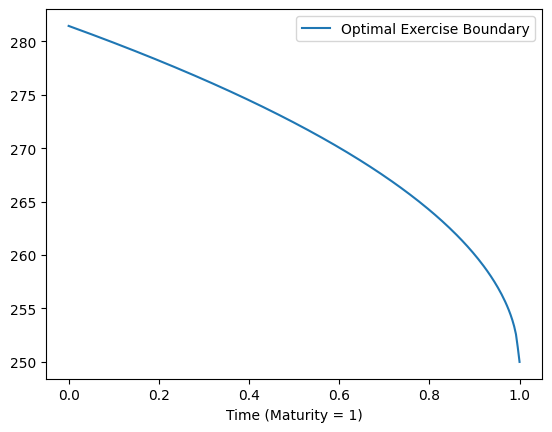

In [13]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Time (Maturity = 1)')

## Convergence analysis

Here, we plot the distribution of the number of steps needed for Newton Raphson procedures to converge.

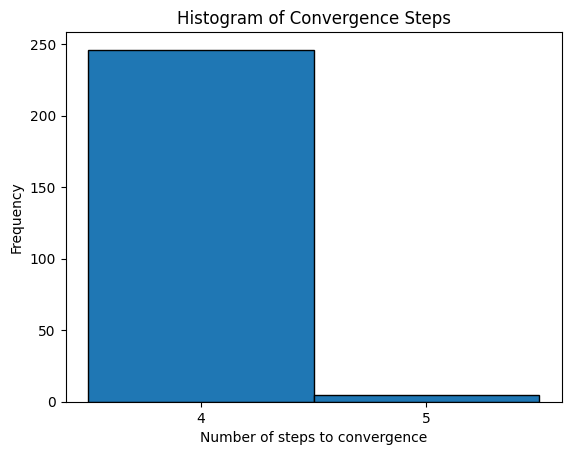

In [14]:
# Convert n_steps_to_convergence to a NumPy array
n_steps_to_convergence_array = np.array(n_steps_to_convergence)

# Assuming n_steps_to_convergence is a NumPy array of integer values:
min_val = n_steps_to_convergence_array.min()
max_val = n_steps_to_convergence_array.max()

# Create bins that cover each integer value. The -0.5 and +0.5 ensure that the bin is centered on the integer.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

plt.hist(n_steps_to_convergence_array, bins=bins, edgecolor='black')
plt.xticks(np.arange(min_val, max_val + 1))  # Set x-ticks to integer values
plt.xlabel('Number of steps to convergence')
plt.ylabel('Frequency')
plt.title('Histogram of Convergence Steps')
plt.show()

In qualitative terms, quadratic convergence means that each iteration typically doubles the number of correct digits. Since our tolerance is set at $10^{-8}$, about four iterations are required to achieve this level of precision, which strongly indicates that our convergence is indeed quadratic.

### What if the number of discretization decreases?

In [15]:
time_discretization = np.linspace(0, time_to_maturity, 32)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

Text(0.5, 0, 'Time (Maturity = 1)')

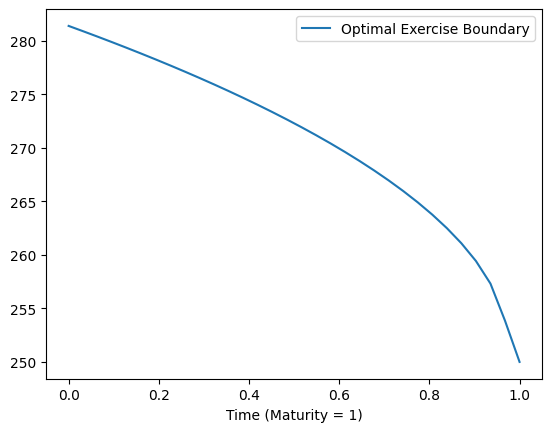

In [16]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Time (Maturity = 1)')

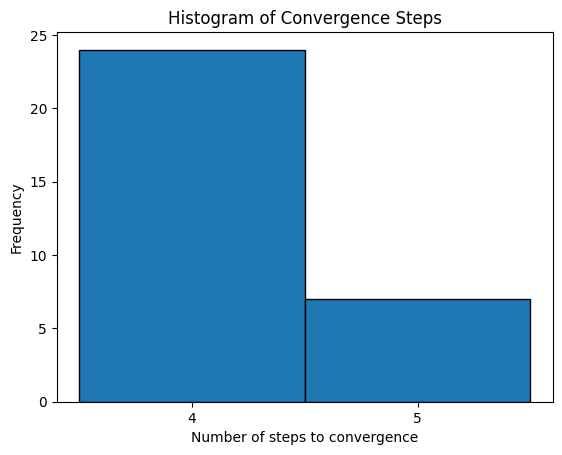

In [17]:
# Convert n_steps_to_convergence to a NumPy array
n_steps_to_convergence_array = np.array(n_steps_to_convergence)

# Assuming n_steps_to_convergence is a NumPy array of integer values:
min_val = n_steps_to_convergence_array.min()
max_val = n_steps_to_convergence_array.max()

# Create bins that cover each integer value. The -0.5 and +0.5 ensure that the bin is centered on the integer.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

plt.hist(n_steps_to_convergence_array, bins=bins, edgecolor='black')
plt.xticks(np.arange(min_val, max_val + 1))  # Set x-ticks to integer values
plt.xlabel('Number of steps to convergence')
plt.ylabel('Frequency')
plt.title('Histogram of Convergence Steps')
plt.show()

As we can see, even the number of discretization is 3, the Newton Raphson still converges. This means that even when the distance between the root and the initial guess is super far, we still have convergence (perhaps even quadratic). Therefore, it is likely that the function $f$ that we are finding the root has very nice property

### The plot of $f$

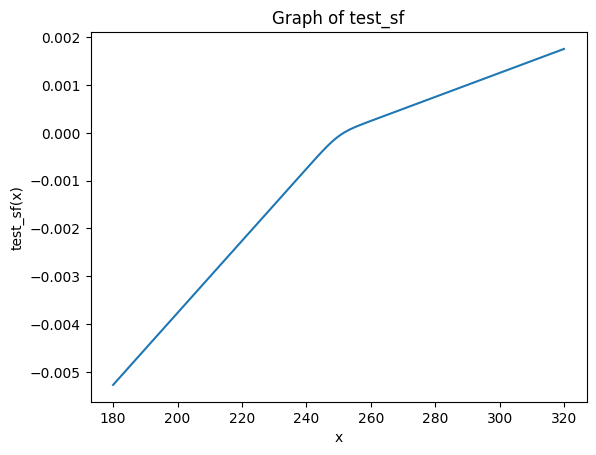

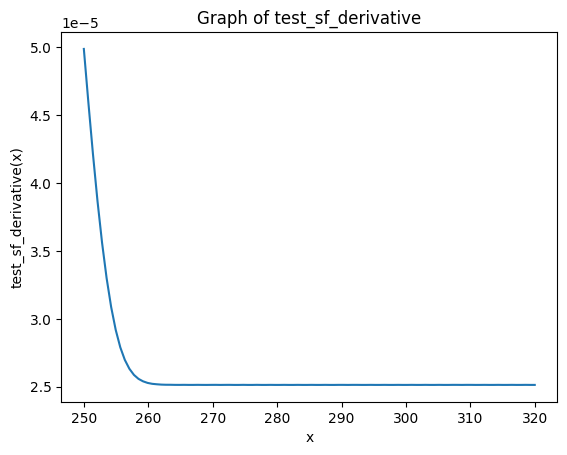

In [18]:
time_discretization = np.linspace(0, time_to_maturity, 200)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    if (i == 198):
        # Plot the graph of test_sf
        x_values = np.linspace(180, 320, 100)
        y_values = [test_sf(x) for x in x_values]
        plt.plot(x_values, y_values)
        plt.xlabel('x')
        plt.ylabel('test_sf(x)')
        plt.title('Graph of test_sf')
        plt.show()
        
        #Plot the graph of test_sf_derivative
        x_values = np.linspace(250, 320, 100)
        y_values = [test_sf_derivative(x) for x in x_values]
        plt.plot(x_values, y_values)
        plt.xlabel('x')
        plt.ylabel('test_sf_derivative(x)')
        plt.title('Graph of test_sf_derivative')
        plt.show()
        break
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

We can clearly see that our function $f$ is concave. From the theoretical result, we can prove that the convergence of Newton-Raphson method is unconditionally guaranteed.

### Verify the convergence rate

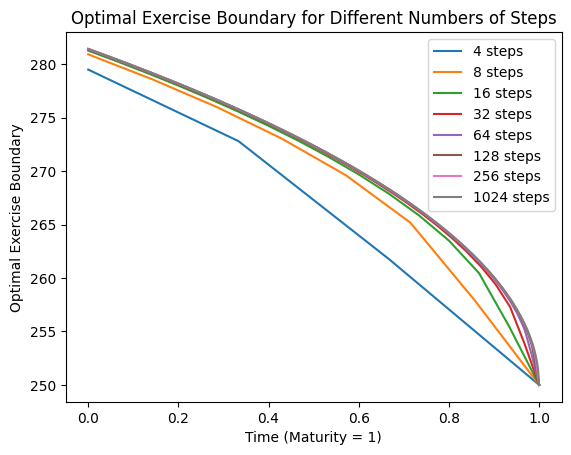

In [19]:
def test_by_n_discretizations(n_discretizations):
    time_discretization = np.linspace(0, time_to_maturity, n_discretizations)
    s_f_list = []
    for _ in range(len(time_discretization)):
        s_f_list.append([0, 0])  # Create a new list for each pair

    s_f_list[-1][1] = max(strike_price, risk_free_rate * strike_price / dividend)
    s_f_list[-1][0] = time_discretization[-1]

    n_steps = len(time_discretization) - 1
    n_steps_to_convergence = []
    for i in range(len(time_discretization) - 2, -1, -1):
        time_passed = i / n_steps
        guess_x = s_f_list[i + 1][1]
        def test_sf(x):
            test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1][1])
            test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
            for j in range(i + 1, len(time_discretization) - 1, 1):
                test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j][1])
                test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1][1])
            return test_result
        def test_sf_derivative(x):
            derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
            derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1][1])
            derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
            for j in range(i + 1, len(time_discretization) - 1):
                derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j][1])
                derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1][1])
            return derivative_result
        
        newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
        s_f_list[i][1] = newton_raphson_result[0]
        s_f_list[i][0] = time_discretization[i]
        n_steps_to_convergence.append(newton_raphson_result[1])
    return s_f_list

test_sizes = [4, 8, 16, 32, 64, 128, 256, 1024]
test_results = []
for (i, test_size) in enumerate(test_sizes):
    test_results.append(test_by_n_discretizations(test_size))
    plt.plot([x[0] for x in test_results[i]], [x[1] for x in test_results[i]], label=f'{test_size} steps')
plt.legend()
plt.xlabel('Time (Maturity = 1)')
plt.ylabel('Optimal Exercise Boundary')
plt.title('Optimal Exercise Boundary for Different Numbers of Steps')
plt.show()

In [20]:
def compute_mse(curve, ground_truth):
    """
    Compute the mean square error between a curve and the ground truth.
    
    Both curve and ground_truth are lists of [time, boundary] pairs.
    We interpolate the given curve to the time grid of ground_truth.
    """
    # Extract time and boundary arrays for the ground truth
    times_gt = np.array([pt[0] for pt in ground_truth])
    boundaries_gt = np.array([pt[1] for pt in ground_truth])
    
    # Extract time and boundary arrays for the curve we are comparing
    times_curve = np.array([pt[0] for pt in curve])
    boundaries_curve = np.array([pt[1] for pt in curve])
    
    # Interpolate the curve's boundary values at the ground truth times.
    boundaries_interp = np.interp(times_gt, times_curve, boundaries_curve)
    
    # Compute the mean squared error between the interpolated values and ground truth.
    mse = np.mean(np.abs(boundaries_interp - boundaries_gt)**2)
    # return the squared root of
    return mse

# Use the 1024 steps version as the ground truth.
ground_truth = test_results[-1]

# Prepare and print the results in a table.
print("Steps\tMSE")
for i, test_size in enumerate(test_sizes):
    # For the ground truth itself, the error is zero.
    if test_size == 1024:
        mse = 0.0
    else:
        mse = compute_mse(test_results[i], ground_truth)
    print(f"{test_size}\t{mse:.6f}")

Steps	MSE
4	24.744224
8	4.559477
16	0.967569
32	0.219174
64	0.050589
128	0.011318
256	0.002217
1024	0.000000


The experiment demonstrates second-order convergence: doubling the number of time steps generally reduces the mean square error by about a factor of four.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13412\317493448.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


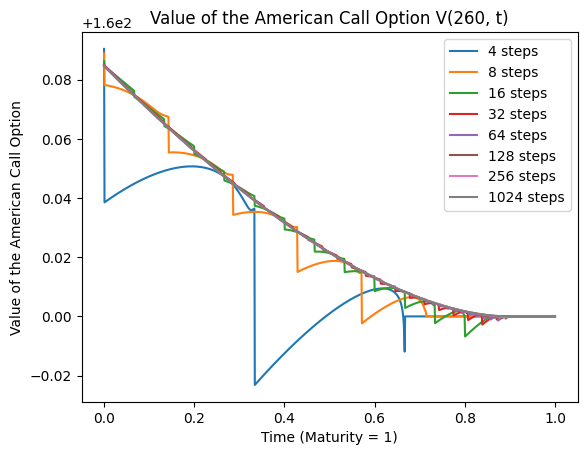

In [21]:
def compute_V(S, t, optimal_exercise_boundary):
    result = M1(S, time_to_maturity - t, strike_price)
    # Use trapezoidal rule to compute \int_t^T Q_1(S,t,u,S_f(u))\,du
    # Find the index of the first time point in the optimal exercise boundary that is greater than t
    idx = np.argmax([pt[0] >= t for pt in optimal_exercise_boundary])
    if (S > optimal_exercise_boundary[idx][1]):
        return S - strike_price
    # Compute the integral using the trapezoidal rule
    for i in range(idx, len(optimal_exercise_boundary) - 1):
        t_i, S_f_i = optimal_exercise_boundary[i]
        t_next, S_f_next = optimal_exercise_boundary[i + 1]
        result += 0.5 * (t_next - t_i) * (Q1(S, t, t_i, S_f_i) + Q1(S, t, t_next, S_f_next))
    return result

S = 260
time_discretization_for_V = np.linspace(0, time_to_maturity, 1024)
V_values = []
for i in range(len(test_results)):
    V_values.append([compute_V(S, t, test_results[i]) for t in time_discretization_for_V])
    plt.plot(time_discretization_for_V, V_values[i], label=f'{test_sizes[i]} steps')
plt.legend()
plt.xlabel('Time (Maturity = 1)')
plt.ylabel('Value of the American Call Option')
plt.title(f'Value of the American Call Option V({S}, t)')
plt.show()

In [22]:
ground_truth = np.array(V_values[-1])  # ground truth V curve (1024 steps)

print("Steps\tMSE")
for i, test_size in enumerate(test_sizes):
    if test_size == test_sizes[-1]:
        mse = 0.0
    else:
        curve = np.array(V_values[i])
        mse = np.mean(np.abs(curve - ground_truth)**2)
        mse = np.sqrt(mse)
    print(f"{test_size}\t{mse:.12f}")

Steps	MSE
4	0.021301007750
8	0.004654626629
16	0.001810032678
32	0.000603213657
64	0.000240197212
128	0.000092953685
256	0.000035858374
1024	0.000000000000


# American Option as Linear Complimentary Problem

## Operator splitting scheme

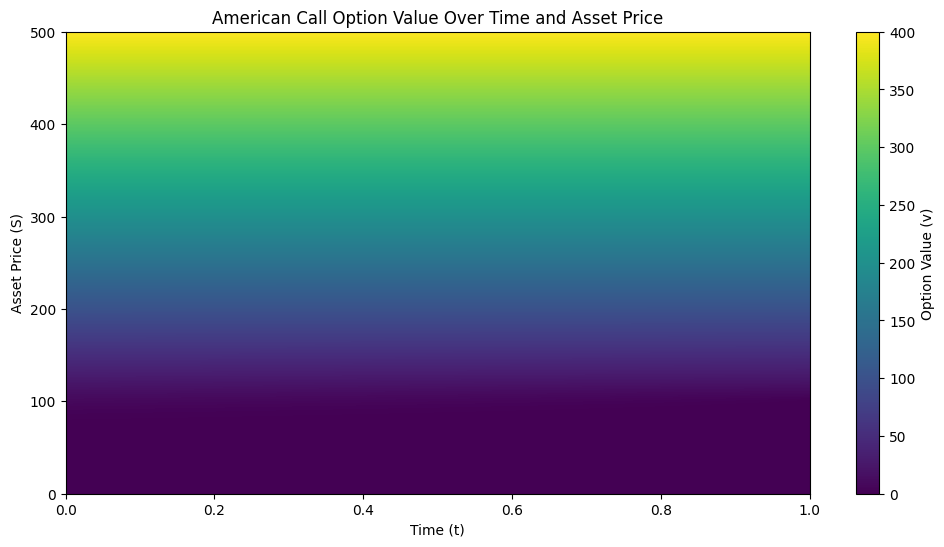

In [25]:
n_timesteps=500
n_spacesteps=1000
alpha=0.5
# Parameters
x_domain = np.linspace(0, 500, n_spacesteps)  # Asset prices
t_domain = np.linspace(0, 1, n_timesteps)  # Time from 0 to T
time_interval = 1.0 / n_timesteps

# Initial condition for v at T (payoff for an American call option)
v_T = np.maximum(x_domain - strike_price, 0)
lambda_T = np.zeros(len(x_domain))

# Matrix A setup for the finite difference method
A = np.zeros((len(x_domain), len(x_domain)))
for i in range(len(x_domain)):
    A[i, i] = - ((volatility * i)**2 + risk_free_rate)
    x_value = x_domain[i]
    if i > 0:
        A[i, i - 1] = 0.5 * (((volatility * i)**2 - (risk_free_rate - dividend) * i))
    if i < len(x_domain) - 1:
        A[i, i + 1] = 0.5 * (((volatility * i)**2 + (risk_free_rate - dividend) * i))

# Storage array for the option values at each time step
v_matrix = np.zeros((len(t_domain), len(x_domain)))
v_matrix[-1, :] = v_T  # Set the terminal condition at t = T

# Backward time-stepping
for i in range(len(t_domain) - 2, -1, -1):
    t = t_domain[i]
    
    # Step 1: LU decomposition to find the intermediate step
    A_prime = -1 / time_interval * np.eye(len(x_domain)) + alpha * A
    B = 1 / time_interval * np.eye(len(x_domain)) + (1 - alpha) * A
    intermediate = np.linalg.solve(A_prime, -np.dot(B, v_T) - lambda_T)

    # Step 2: Projection step to enforce the early-exercise constraint
    v_new = np.copy(intermediate)  # Start with the intermediate values as a base
    for j in range(len(x_domain)):
        # Calculate the payoff at this point (for an American call, payoff = max(x - strike_price, 0))
        payoff = max(x_domain[j] - strike_price, 0)
        # Enforce the constraint: v >= payoff
        if v_new[j] + time_interval * lambda_T[j] < payoff:
            v_new[j] = payoff
            lambda_T[j] = max(lambda_T[j] + (1 / time_interval) * (intermediate[j] - v_new[j]), 0)
        else:
            v_new[j] = v_new[j] + time_interval * lambda_T[j]
            lambda_T[j] = 0
    # Update v_T for the next time step
    v_T = v_new
    # Store the new v_T in the matrix for plotting
    v_matrix[i, :] = v_T

# Plotting the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(v_matrix.T, extent=[0, 1, 0, 500], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Option Value (v)")
plt.xlabel("Time (t)")
plt.ylabel("Asset Price (S)")
plt.title("American Call Option Value Over Time and Asset Price")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13412\317493448.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


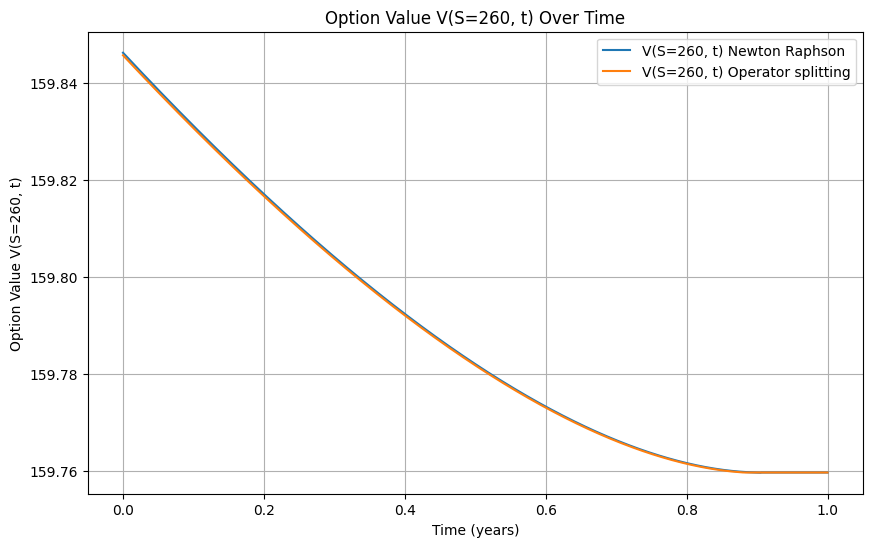

In [41]:
# Find the index in x_domain closest to S = 100
S_target = 260
S_index = np.argmin(np.abs(x_domain - S_target))

# Newton Raphson
V_S_over_time = [compute_V(x_domain[S_index], t, test_results[-1]) for t in time_discretization_for_V]

# Generate time array in years for plotting
time_array = np.linspace(0, time_to_maturity, n_timesteps)
plt.figure(figsize=(10, 6))
plt.plot(time_discretization_for_V, V_S_over_time, label=f'V(S={S_target}, t) Newton Raphson')
plt.plot(t_domain, v_matrix[:, S_index], label=f'V(S={S_target}, t) Operator splitting')
plt.xlabel('Time (years)')
plt.ylabel(f'Option Value V(S={S_target}, t)')
plt.title(f'Option Value V(S={S_target}, t) Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Convergence rate

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13412\317493448.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


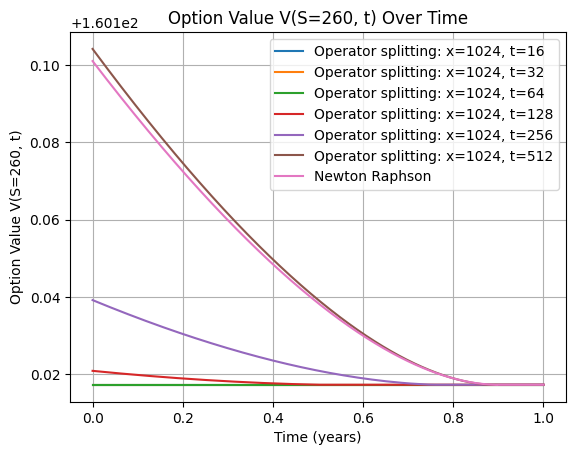

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def thomas_solver(a, b, c, d):
    """
    Solve the tridiagonal system Ax = d
    where:
      - a is the sub-diagonal (length n-1)
      - b is the main diagonal (length n)
      - c is the super-diagonal (length n-1)
      - d is the right-hand side (length n)
    Returns x (length n)
    """
    n = len(b)
    # Copy arrays to avoid modifying the originals
    ac, bc, cc, dc = a.copy(), b.copy(), c.copy(), d.copy()
    
    # Forward sweep
    for i in range(1, n):
        m = ac[i-1] / bc[i-1]
        bc[i] = bc[i] - m * cc[i-1]
        dc[i] = dc[i] - m * dc[i-1]
    
    # Back substitution
    x = np.empty(n)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x

def operator_splitting(n, m):
    x_domain = np.linspace(0, 300, n)  # Asset prices
    t_domain = np.linspace(0, 1, m)      # Time from 0 to T
    time_interval = 1.0 / n_timesteps   # Assuming n_timesteps is defined globally

    # Initial condition for v at T (payoff for an American call option)
    v_T = np.maximum(x_domain - strike_price, 0)
    lambda_T = np.zeros(len(x_domain))

    # Matrix A setup for the finite difference method (tridiagonal structure)
    A = np.zeros((len(x_domain), len(x_domain)))
    for i in range(len(x_domain)):
        A[i, i] = - ((volatility * i)**2 + risk_free_rate)
        if i > 0:
            A[i, i - 1] = 0.5 * (((volatility * i)**2 - (risk_free_rate - dividend) * i))
        if i < len(x_domain) - 1:
            A[i, i + 1] = 0.5 * (((volatility * i)**2 + (risk_free_rate - dividend) * i))

    # Preallocate storage for the option values at each time step
    v_matrix = np.zeros((len(t_domain), len(x_domain)))
    v_matrix[-1, :] = v_T  # Terminal condition at t = T

    # Backward time-stepping
    for i in range(len(t_domain) - 2, -1, -1):
        # Step 1: Formulate the system using the TR-BDF splitting
        A_prime = -1 / time_interval * np.eye(len(x_domain)) + alpha * A
        B = 1 / time_interval * np.eye(len(x_domain)) + (1 - alpha) * A
        d = -np.dot(B, v_T) - lambda_T  # Right-hand side for the linear system

        # Extract diagonals from A_prime (tridiagonal)
        diag = np.diag(A_prime)
        lower = np.diag(A_prime, k=-1)
        upper = np.diag(A_prime, k=1)

        # Solve using the Thomas algorithm
        intermediate = thomas_solver(lower, diag, upper, d)

        # Step 2: Projection step to enforce the early-exercise constraint
        v_new = np.copy(intermediate)
        for j in range(len(x_domain)):
            payoff = max(x_domain[j] - strike_price, 0)
            if v_new[j] + time_interval * lambda_T[j] < payoff:
                v_new[j] = payoff
                lambda_T[j] = max(lambda_T[j] + (1 / time_interval) * (intermediate[j] - v_new[j]), 0)
            else:
                v_new[j] = v_new[j] + time_interval * lambda_T[j]
                lambda_T[j] = 0
        v_T = v_new
        v_matrix[i, :] = v_T  # Store for plotting
    return v_matrix

# Example plotting for different discretizations
x_discretizations = [1024,1024,1024,1024,1024,1024]
t_discretization = [16, 32, 64, 128, 256, 512]

# Ensure the following parameters are defined:
# n_timesteps, strike_price, volatility, risk_free_rate, dividend, alpha, S_target

for x_size, t_size in zip(x_discretizations, t_discretization):
    cur_v_matrix = operator_splitting(x_size, t_size)
    cur_x = np.linspace(0, 300, x_size)
    cur_t = np.linspace(0, 1, t_size)
    S_index = np.argmin(np.abs(cur_x - S_target))
    plt.plot(cur_t, cur_v_matrix[:, S_index], label=f'Operator splitting: x={x_size}, t={t_size}')

#Also plot the ground truth
cur_x = np.linspace(0, 300, 1024)
S_index = np.argmin(np.abs(cur_x - S_target))
V_S_over_time = [compute_V(cur_x[S_index], t, test_results[-1]) for t in time_discretization_for_V]
plt.plot(time_discretization_for_V, V_S_over_time, label='Newton Raphson')

plt.xlabel('Time (years)')
plt.ylabel(f'Option Value V(S={S_target}, t)')
plt.title(f'Option Value V(S={S_target}, t) Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: Different time discretizations with a fixed spatial discretization
t_discretization = [16, 32, 64, 128, 256, 512]
x_size = 1024  # Fixed spatial discretization

# List to store the MSE results
results = []

for t_size in t_discretization:
    # Run operator splitting method for current time discretization
    cur_v_matrix = operator_splitting(x_size, t_size)
    
    # Construct current grids
    cur_x = np.linspace(0, 300, x_size)
    cur_t = np.linspace(0, 1, t_size)
    
    # Find the index closest to the target asset price S_target
    S_index = np.argmin(np.abs(cur_x - S_target))
    
    # Extract the operator splitting option values over time at S_target
    operator_values = cur_v_matrix[:, S_index]
    
    # Interpolate the ground truth (Newton–Raphson) values to the current time grid
    ground_truth_interp = np.interp(cur_t, time_discretization_for_V, V_S_over_time)
    
    # Compute the Mean Squared Error (MSE)
    mse = np.mean((operator_values - ground_truth_interp) ** 2)
    
    results.append({
        't_discretization': t_size,
        'MSE': mse
    })

# Create a DataFrame for a clear tabular display
df_mse = pd.DataFrame(results)
print(df_mse)


   t_discretization       MSE
0                16  0.001590
1                32  0.001520
2                64  0.001486
3               128  0.001379
4               256  0.000847
5               512  0.000002


## Stability

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\ticker.py:2119: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


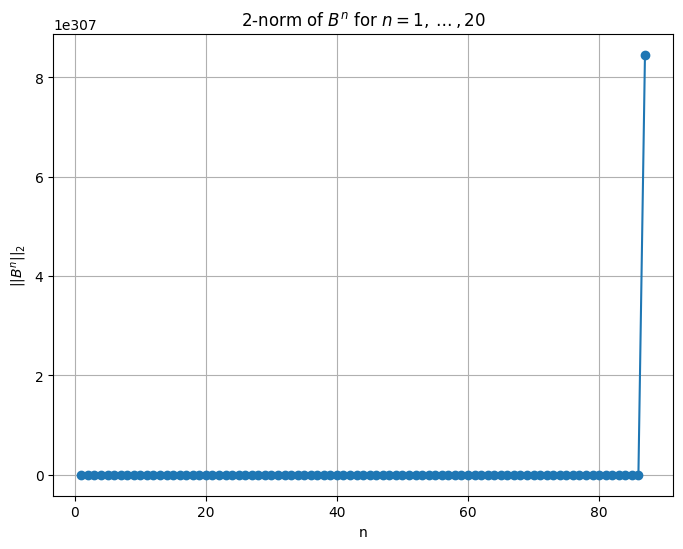

In [78]:
A = np.zeros((len(x_domain), len(x_domain)))
for i in range(len(x_domain)):
    if i == len(x_domain) - 1:
        continue
    A[i, i] = - ((volatility * i)**2 + risk_free_rate)
    if i > 0:
        A[i, i - 1] = 0.5 * (((volatility * i)**2 - (risk_free_rate - dividend) * i))
    if i < len(x_domain) - 1:
        A[i, i + 1] = 0.5 * (((volatility * i)**2 + (risk_free_rate - dividend) * i))

# Define B = (I + 1/2 * dt * A)^{-1} * (I - 1/2 * dt * A)
B = np.eye(len(x_domain)) + 0.5 * time_interval * A
B_inv = np.linalg.inv(B)

B = np.eye(len(x_domain)) - 0.5 * time_interval * A
B = B_inv @ B

# Let n be from 1 to 20, calculate ||B^n||_2 and plot the result
n_values = np.arange(1, 100)
norm_values = []

for n in n_values:
    B_power = np.linalg.matrix_power(B, n)
    norm_val = np.linalg.norm(B_power, 2)  # 2-norm (spectral norm)
    norm_values.append(norm_val)

# Plot the result
plt.figure(figsize=(8,6))
plt.plot(n_values, norm_values, marker='o')
plt.xlabel('n')
plt.ylabel(r'$||B^n||_2$')
plt.title(r'2-norm of $B^n$ for $n=1,\dots,20$')
plt.grid(True)
plt.show()
